
In this notebook, you will deploy a simple RNN for predicting the next value of a given Time-Series given past observations. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Part I. Create target signal

We will generate a target signal of length $T=200$ time steps. We generate the signal as one realization of the following autoregressive model
\begin{align}
X_{t}=c+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\varepsilon_{t}
\end{align}
where we will use $c=0$, $p=3$, $\varphi_1=0.8$, $\varphi_2=-0.2$, and $\varphi_3=0.2$. Also, $\varepsilon\sim\mathcal{N}(0,0.1)$.

The goal of the RNN will be to predict the next value of the signal given the current observation.

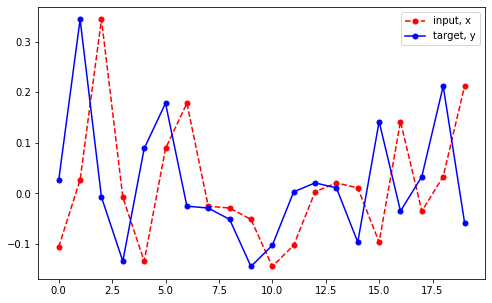

In [ ]:
N = 1 # A single signal

T = 200

c = 0

phi_1 = 0.1

phi_2 = -0.2

phi_3 = 0.2

sigma = 0.01

X = np.zeros([N,T])

X[:,0] = c + np.random.randn(N,)*np.sqrt(sigma)

X[:,1] = c + phi_1 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,2] = c + phi_1 * X[:,1] + phi_2 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

X[:,3] = c + phi_1 * X[:,2] + phi_2 * X[:,1] + phi_3 * X[:,0] + np.random.randn(N,)*np.sqrt(sigma)

t = 4

while (t<T):

    X[:,t] = c + phi_1 * X[:,t-1] + phi_2 * X[:,t-2] + phi_3 * X[:,t-3] + np.random.randn(N,)*np.sqrt(sigma)
    
    t +=1
    

# Create targets

Y = X[:,1:] # all but the first
X = X[:,:-1] # all but the last piece of data

T -=1


# Plot the signal (the first 20 timesteps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[0,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[0,:20], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

## Part II. Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, which takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a **stacked RNN**.
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

If you take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn), you will see that `nn.RNN` only provides the actual computation of the hidden states along time
\begin{align}
h_{t}=g \left(W_{i h} x_{t}+b_{i h}+W_{h h} h_{(t-1)}+b_{h h}\right)
\end{align}

Then we'll add a last, fully-connected layer to get the output size that we want. For simplicity, **the input to this dense layer is the state $h_t$ of the RNN**.

You have to pay special attention to the dimensions of the input/output tensors of the RNN. **CHECK THE [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn)**.

>**Exercise:** Complete the following code

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size

        self.output_size = output_size

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, nonlinearity='relu',batch_first=True)
        
        # last, fully-connected layer  # es la capa que se encarga de la prediccion
        self.fc1 = nn.Linear(hidden_dim,output_size) # YOUR CODE HERE

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim) --> State initialization! 
        # r_out (batch_size, seq_length, hidden_size)
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden) 
        # r_out = es un vector de todos los estados hasta ese momento
        # hidden = ultimo estado actualizado 
      
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        
        output = self.fc1(r_out)# YOUR CODE HERE
        
        # reshape back to temporal structure
        output = output.reshape([-1,seq_length,1])
        
        return output, hidden


In [ ]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=1)

In [ ]:
X_in = torch.Tensor(X).view([1,T,1])
h_0 = torch.zeros([1,1,10])

o,h = test_rnn.forward(X_in,h_0)

print(h.shape)

print(o.shape)

torch.Size([1, 1, 10])
torch.Size([1, 199, 1])


> **Exercise:** Complete the code for the following class, which extends `RNN` to include a training method. 

Since we only have one signal, there is no mini-batch. We feed the forward method with that signal all the time

In [ ]:
class RNN_extended(RNN):
    
    #Your code here
    
    def __init__(self, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()         
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.predicted = []
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad()  #TO RESET GRADIENTS!
                
            x = torch.Tensor(x).view([1,self.sequence_length,1])

            y = torch.Tensor(y).view([1,self.sequence_length,1])
                
            h_0 = torch.zeros([self.num_layers,1,self.hidden_dim])

            out,hid = self.forward(x,h_0)
            
            self.predicted.append(out.data.numpy().flatten())
            
            loss = self.criterion(out,y)
            
            loss.backward()
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))       


                    

> **Exercise:** Train the RNN for 500 SGD iterations with a hidden state of dimension 32

In [ ]:
# YOUR CODE HERE
my_rnn = RNN_extended(num_iter=500,sequence_length=T, input_size=1, output_size=1, hidden_dim=32, n_layers=1)

my_rnn.trainloop(X,Y)

Iteration 0. Training loss: 0.000070
Iteration 50. Training loss: 0.000021
Iteration 100. Training loss: 0.000020
Iteration 150. Training loss: 0.000019
Iteration 200. Training loss: 0.000018
Iteration 250. Training loss: 0.000018
Iteration 300. Training loss: 0.000018
Iteration 350. Training loss: 0.000017
Iteration 400. Training loss: 0.000017
Iteration 450. Training loss: 0.000016


> **Exercise:** Plot the loss function along training

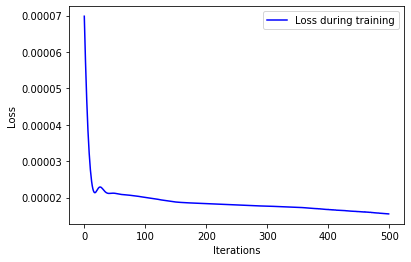

In [ ]:
# YOUR CODE HERE

plt.plot(my_rnn.loss_during_training,'-b',label='Loss during training')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

> **Exercise:** Plot the input signal, the target one, and the predicted by the RNN

(500, 199)


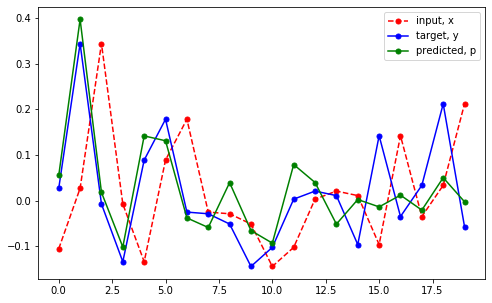

In [ ]:
# YOUR CODE HERE

print(np.shape(my_rnn.predicted))
# Plot the signal (the first 20 timesteps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[0,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[0,:20], 'b.-', label='target, y',ms=10) # y
plt.plot(np.arange(20),my_rnn.predicted[499][:20], 'g.-', label='predicted, p',ms=10) # p
plt.legend(loc='best')